In [1]:
# load all the points in a ply file
import plyfile
import numpy as np

def load_ply(file_name):
    ply_data = plyfile.PlyData.read(file_name)
    vertices = ply_data['vertex']
    
    points = np.vstack([vertices['x'], vertices['y'], vertices['z']]).T
    return points

# get points from the ply file
points = load_ply("../data/lego-points/lego.ply")

In [2]:
points

array([[ 0.37207645, -0.05386647, -0.1073141 ],
       [ 0.36826754, -0.05412292, -0.10702634],
       [ 0.36826754, -0.05595155, -0.10848077],
       ...,
       [ 0.30314648, -0.1568041 , -0.16758667],
       [ 0.31586182, -0.13868539, -0.12213587],
       [ 0.31586182, -0.16942944, -0.12213587]], dtype=float32)

In [3]:
# visualize the points
import matplotlib.pyplot as plt

def viz_points(points, other_color=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # compute color based on distance to camera
    if other_color is not None:
        col = other_color
    else:
        col = np.linalg.norm(points - np.array([1, -1, 1]), axis=1)
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0.1, c=col)
    plt.show()

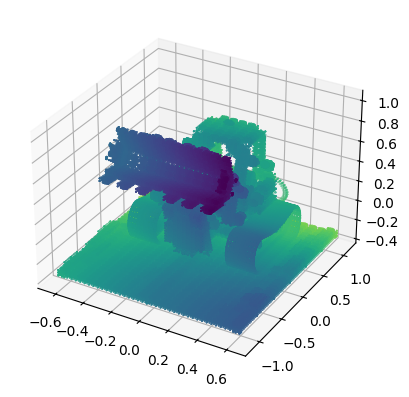

In [4]:
viz_points(points)

In [5]:
# compute and output the bounds of the points

def compute_bounds(points):
    return np.min(points, axis=0), np.max(points, axis=0)

min_bound, max_bound = compute_bounds(points)

min_bound, max_bound

(array([-0.63778746, -1.1400161 , -0.34465563], dtype=float32),
 array([0.6337443, 1.1487377, 1.002206 ], dtype=float32))

In [6]:
# create a loadnelf lego dataset
from lodnelf.data.lego_dataset import LegoDataset

train_dataset = LegoDataset("../data/lego", split="train", limit=1)

In [7]:
train_dataset[0]

(tensor([-0.0538,  3.8455,  1.2081]),
 tensor([ 0.3340, -0.9418,  0.0390]),
 tensor([0., 0., 0., 0.]))

In [8]:
def viz_data_point_dir(data_point):
    ray_origin, ray_dir_world, col = data_point

    op = points - ray_origin.numpy()
    len_proj = (op @ ray_dir_world.numpy())
    op_proj = ray_dir_world.numpy() * len_proj[:, None]
    other_color = 1- np.linalg.norm(op - op_proj, axis=1)


    viz_points(points, other_color)

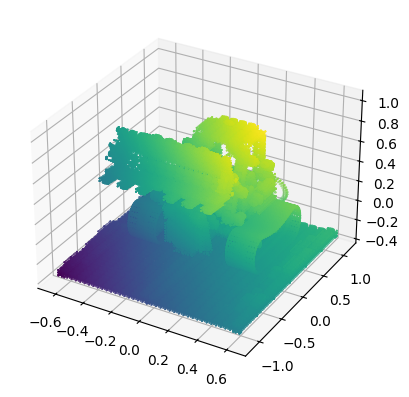

In [111]:
viz_data_point_dir(train_dataset[0])

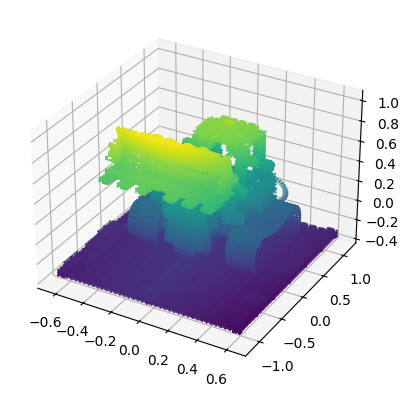

In [112]:
viz_data_point_dir(train_dataset[1231])

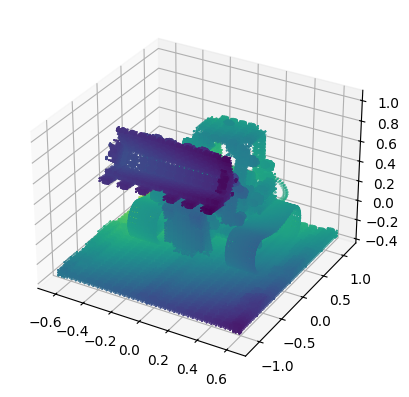

In [113]:
viz_data_point_dir(train_dataset[len(train_dataset) - 1])

In [9]:
import random

def stratified_sampling(points, k):
    """Select k points using stratified sampling to ensure even distribution."""
    # Determine the bounding box of the points
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    bbox_size = max_coords - min_coords
    
    # Define the number of divisions along each axis
    divisions = int(np.cbrt(k))  # Cube root to divide into approximately equal grid cells
    cell_size = bbox_size / divisions
    
    # Create a dictionary to hold points in each grid cell
    grid = {}
    for point in points:
        cell_index = tuple(((point - min_coords) // cell_size).astype(int))
        if cell_index not in grid:
            grid[cell_index] = []
        grid[cell_index].append(point)
    
    # Select one point from each non-empty grid cell until we have k points
    selected_points = []
    for cell_points in grid.values():
        selected_points.append(random.choice(cell_points))
        if len(selected_points) >= k:
            break
    
    # If we don't have enough points yet, randomly select remaining points
    if len(selected_points) < k:
        remaining_points = np.array([p for sublist in grid.values() for p in sublist])
        remaining_points = remaining_points[np.random.choice(remaining_points.shape[0], k - len(selected_points), replace=False)]
        selected_points.extend(remaining_points)
    
    return np.array(selected_points)

In [10]:
selected_points = stratified_sampling(points, 256 * 2)

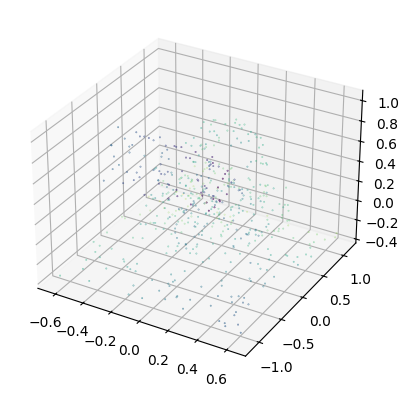

In [11]:
viz_points(selected_points)

In [12]:
256 * 2

512

In [67]:
from typing import List
from torch import nn
import torch
from lodnelf.model.components.deep_neural_network import DeepNeuralNetwork

class PointBasedNelf(nn.Module):
    def __init__(self, initial_points, embed_size, hidden_dims: List[int]):
        super(PointBasedNelf, self).__init__()

        self.points = nn.Parameter(torch.from_numpy(initial_points), requires_grad=True)
        self.embed_size = embed_size

        self.embedded_parameters = nn.Parameter(
            torch.randn(self.points.shape[0], embed_size)
        )

        self.dnn = DeepNeuralNetwork(embed_size, hidden_dims, 4)

    def forward(self, input):
        # input is a tuple of ray_origin, ray_dir_world
        ray_origin, ray_dir_world, _ = input

        # compute the distance to the points
        points_translated = self.points.unsqueeze(0) - ray_origin.unsqueeze(1)
        project_to_ray = (points_translated @ ray_dir_world.unsqueeze(2)).squeeze(2) / torch.norm(ray_dir_world, dim=-1).unsqueeze(1)
        on_ray = ray_dir_world.unsqueeze(1) * project_to_ray.unsqueeze(2)
        weight = torch.exp(-torch.norm(points_translated - on_ray, dim=-1))
        
        # compute the embedding
        embedded_points = self.embedded_parameters
        weighted_points = embedded_points * weight.unsqueeze(2)
        embedded_points = torch.sum(weighted_points, dim=1)
        
        #compute the output
        output = self.dnn(embedded_points)

        return output

In [68]:
# create the model
model = PointBasedNelf(selected_points, 64, [128, 128, 128])

In [73]:
# train the model

from torch.utils.data import DataLoader
from torch import optim
from lodnelf.data.lego_dataset import LegoDataset
from tqdm import tqdm

# create the dataset
train_dataset = LegoDataset("../data/lego", split="train")

# create the dataloader
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# create the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# create the loss function
loss_fn = nn.MSELoss()

# train the model
for epoch in range(10):
    running_loss = 0
    for data_point in tqdm(dataloader):
        ray_origin, ray_dir_world, col = data_point
        optimizer.zero_grad()

        output = model(data_point)

        loss = loss_fn(output, col)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, Loss {running_loss / len(dataloader)}")

  3%|▎         | 30807/1000000 [06:46<3:32:58, 75.84it/s]

KeyboardInterrupt: 

Validation Loss 0.021182147580524613


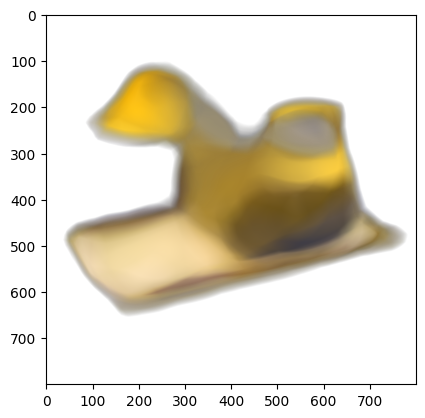

In [76]:
val_dataset = LegoDataset("../data/lego", split="val", limit=13)

# evaluate the model
with torch.no_grad():
    rgba = []
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=64,
        sampler=list(range(12 * 800 * 800, 13 * 800 * 800)),
    )
    running_loss = 0
    for data_point in tqdm(val_dataloader):
        ray_origin, ray_dir_world, col = data_point

        output = model(data_point)
        rgba.extend(output)

        loss = loss_fn(output, col)
        running_loss += loss.item()

    print(f"Validation Loss {running_loss / len(val_dataloader)}")
    # visualize the output
    rgba = torch.cat(rgba, dim=0).reshape(-1, 4)
    rgba = rgba.numpy()
    rgba = np.clip(rgba, 0, 1)
    plt.imshow(rgba.reshape(800, 800, 4))
    plt.show()

In [62]:
rgba.reshape(800, 800, 5))

SyntaxError: unmatched ')' (3123590151.py, line 1)

 16%|█▌        | 1009/6400 [00:07<00:41, 130.70it/s]

KeyboardInterrupt: 

In [70]:
rgba

[tensor([0.0000, 0.2353, 0.0000, 0.0000]),
 tensor([0.0000, 0.2358, 0.0000, 0.0000]),
 tensor([0.0000, 0.2363, 0.0000, 0.0000]),
 tensor([0.0000, 0.2368, 0.0000, 0.0000]),
 tensor([0.0000, 0.2373, 0.0000, 0.0000]),
 tensor([0.0000, 0.2378, 0.0000, 0.0000]),
 tensor([0.0000, 0.2383, 0.0000, 0.0000]),
 tensor([0.0000, 0.2388, 0.0000, 0.0000]),
 tensor([0.0000, 0.2393, 0.0000, 0.0000]),
 tensor([0.0000, 0.2398, 0.0000, 0.0000]),
 tensor([0.0000, 0.2403, 0.0000, 0.0000]),
 tensor([0.0000, 0.2408, 0.0000, 0.0000]),
 tensor([0.0000, 0.2413, 0.0000, 0.0000]),
 tensor([0.0000, 0.2418, 0.0000, 0.0000]),
 tensor([0.0000, 0.2423, 0.0000, 0.0000]),
 tensor([0.0000, 0.2428, 0.0000, 0.0000]),
 tensor([0.0000, 0.2433, 0.0000, 0.0000]),
 tensor([0.0000, 0.2438, 0.0000, 0.0000]),
 tensor([0.0000, 0.2443, 0.0000, 0.0000]),
 tensor([0.0000, 0.2448, 0.0000, 0.0000]),
 tensor([0.0000, 0.2453, 0.0000, 0.0000]),
 tensor([0.0000, 0.2458, 0.0000, 0.0000]),
 tensor([0.0000, 0.2464, 0.0000, 0.0000]),
 tensor([0.

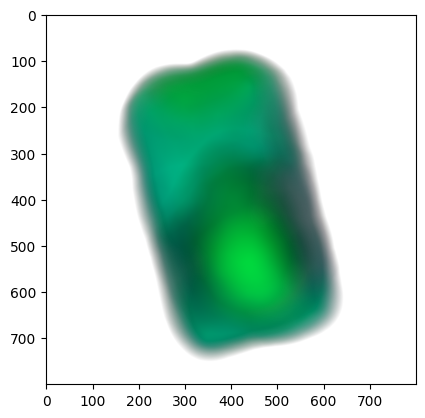

In [42]:
# reshape tensor to image
rgba = torch.cat(rgba, dim=0)


TypeError: cat() received an invalid combination of arguments - got (Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [47]:
28480 ** 0.5

168.7601848778319

In [245]:
# test the model on a validation datapoint

train_dataset = LegoDataset("../data/lego", split="val", limit=1)

dataloader = DataLoader(train_dataset, batch_size=64)

rgba = []

with torch.no_grad():
    for data_point in dataloader:
        ray_origin, ray_dir_world, col = data_point

        output = model(data_point)

        rgba.extend(output.detach().numpy())